Epoch 1/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 716ms/step - accuracy: 0.4866 - loss: 0.6997 - val_accuracy: 0.5294 - val_loss: 0.6927
Epoch 2/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5084 - loss: 0.6981 - val_accuracy: 0.5294 - val_loss: 0.6919
Epoch 3/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4906 - loss: 0.6930 - val_accuracy: 0.4706 - val_loss: 0.6957
Epoch 4/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4933 - loss: 0.6945 - val_accuracy: 0.4706 - val_loss: 0.6983
Epoch 5/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5198 - loss: 0.6924 - val_accuracy: 0.4706 - val_loss: 0.6944
Epoch 6/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5032 - loss: 0.6938 - val_accuracy: 0.5294 - val_loss: 0.6920
Epoch 7/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5106 - loss: 0.6924 - val_accuracy: 0.4706 - val_loss: 0.6946
Epoch 8/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5211 - loss: 0.6928 - val_accuracy: 0.4706 - val_loss: 0.694

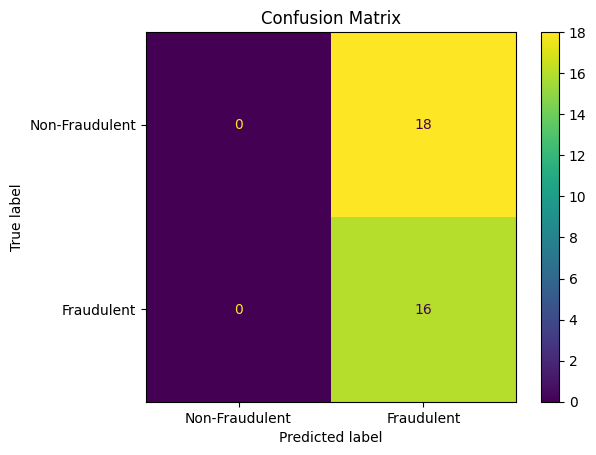

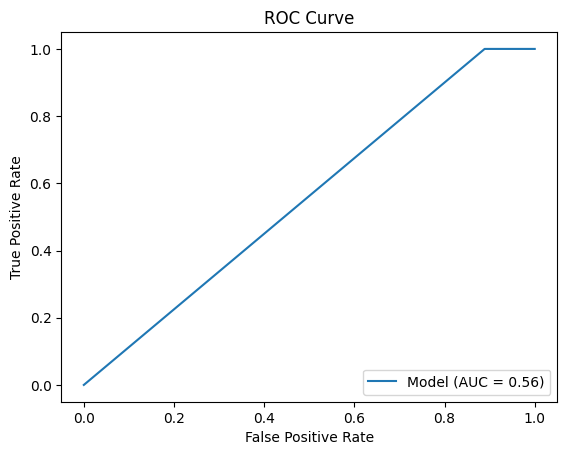

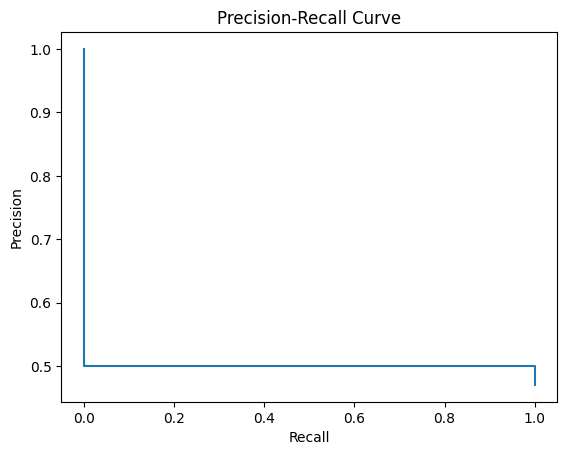

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, Attention, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TimeDistributed
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.layers import GlobalAveragePooling1D
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


# Constants
MAX_NB_WORDS = 50000  
EMBEDDING_DIM = 300   
MAX_SENT_LENGTH = 50   
MAX_SENTS = 15     

# Reading the data
data = pd.read_csv('/kaggle/input/financial-statement-fraud-data/Final_Dataset.csv')
texts = data['Fillings'].tolist()
data['Fraud'] = data['Fraud'].map({'yes': 1, 'no': 0})
labels = data['Fraud'].astype(int).tolist()


# Tokenize sentences and words
texts = [[sent[:MAX_SENT_LENGTH] for sent in sent_tokenize(text)[:MAX_SENTS]] for text in texts]

# Word Tokenization and Padding
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts([word for sent in doc for word in sent] for doc in texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(texts):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = tokenizer.texts_to_sequences([sent])[0]
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH:
                    data[i, j, k] = word
                    k = k + 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert labels to arrays
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)


# Word-level attention
word_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
word_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(word_input)
word_lstm = LSTM(150, return_sequences=True)(word_sequences)
word_attention = GlobalAveragePooling1D()(word_lstm)
word_encoder = Model(word_input, word_attention)

# Sentence-level attention
sent_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
sent_encoder = TimeDistributed(word_encoder)(sent_input)
sent_lstm = LSTM(150, return_sequences=True)(sent_encoder)
sent_attention = GlobalAveragePooling1D()(sent_lstm)
preds = Dense(1, activation='sigmoid')(sent_attention)
model = Model(sent_input, preds)

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=17, batch_size=32)

# Predicting the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculating the metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, pos_label=1)
recall = recall_score(y_test, y_pred_classes, pos_label=1)
f1 = f1_score(y_test, y_pred_classes, pos_label=1)

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("Validation F1-score:", f1)

# Predicting the probabilities for the test set
y_pred_probs = model.predict(X_test)

# Use a threshold of 0.5 to determine class labels
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# 1. Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraudulent", "Fraudulent"])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# 2. Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model')
roc_display.plot()
plt.title('ROC Curve')
plt.show()

# 3. Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.show()